In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37267")
client

<Client: 'tcp://127.0.0.1:37267' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import gsw
import time
import gcm_filters
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
# from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
from scipy.stats import pearsonr
# import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
# from xhistogram.xarray import histogram as xhist
# import xrft
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.lines import Line2D
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'
spec = '/tank/spectre/tuchida/TWA/'

In [4]:
year = 1967

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
ts, bs = (13,48)
nremap = 50
nsig = 25

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
dnf = 2160
nfile = 73
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0   # 1490400
yystart = 0
ntimes[yystart,dd:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

/tmp/ipykernel_51193/3692156320.py:31: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/'
/tmp/ipykernel_51193/3692156320.py:38: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidate

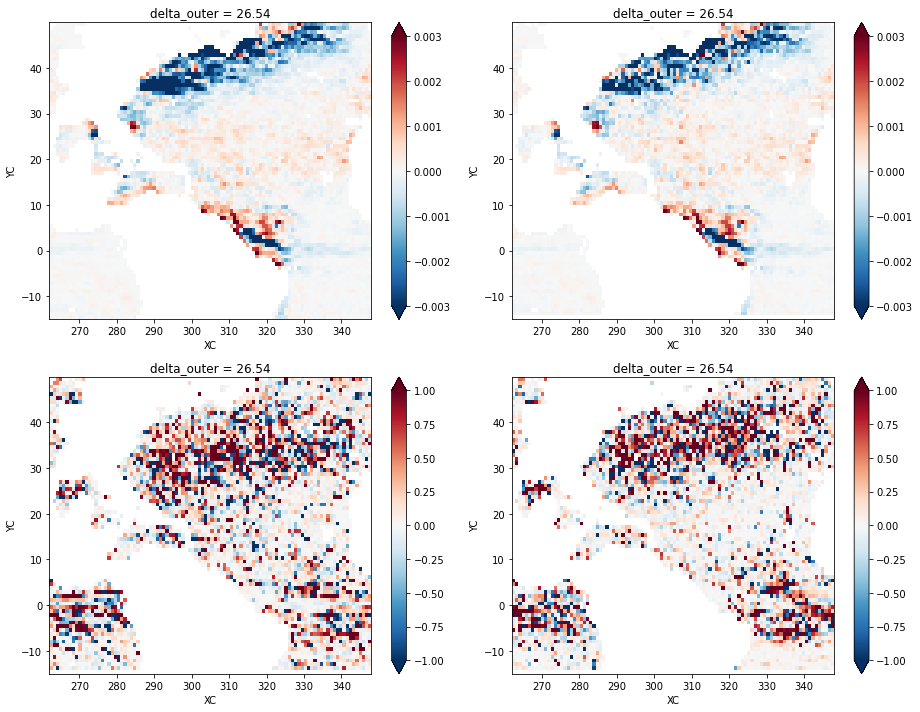

<xarray.Dataset>
Dimensions:      (XC: 100, YC: 78, delta_outer: 35)
Coordinates:
  * XC           (XC) float32 262.4 263.2 264.1 265.0 ... 345.9 346.7 347.6
  * YC           (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * delta_outer  (delta_outer) float64 24.21 24.49 24.76 ... 28.87 28.92 28.96
    Depth        (YC, XC) float32 dask.array<chunksize=(39, 25), meta=np.ndarray>
    maskInC      (YC, XC) float64 dask.array<chunksize=(39, 25), meta=np.ndarray>
Data variables:
    ex0          (delta_outer, YC, XC) float64 dask.array<chunksize=(7, 39, 25), meta=np.ndarray>
    ey0          (delta_outer, YC, XC) float64 dask.array<chunksize=(7, 39, 25), meta=np.ndarray>
    ex1          (delta_outer, YC, XC) float64 dask.array<chunksize=(7, 39, 25), meta=np.ndarray>
    ey1          (delta_outer, YC, XC) float64 dask.array<chunksize=(7, 39, 25), meta=np.ndarray>
    ex2          (delta_outer, YC, XC) float64 dask.array<chunksize=(7, 39, 25), meta=np.ndarray>
    ey2      

In [43]:
yy = yystart
# xlim = [270,340]

for year in years:
    
    if year == years[yystart]:
        mtimes = ntimes[yy,:1]
        ystart = ySstart
    else:
        mtimes = ntimes[yy]
        ystart = ySstart
        
    for itime in mtimes:
        
        K = xr.open_zarr(op.join(spec,
                                 '5Dave/run%4d/Diff-tensor/explicit/no-skipNaN/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr' 
                                 % (year,50,10,ySstart,yend,itime))
                        ).K
        ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,year)), 
                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).chunk({'XC':xchunk,'XG':xchunk,
                                          'YC':ychunk,'YG':ychunk})
        nmembs = np.arange(36,60)
        for memb in nmembs:
            if memb == 36:
                dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                                   % (year,memb,itime))
                                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                YG=slice(ystart-12**-1,yend+2*12**-1)
                                               ).reset_coords(drop=True).isel(time=0)

            else:
                dsz = xr.concat([dsz, xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                                           % (year,memb,itime))
                                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                                       ).reset_coords(drop=True).isel(time=0)
                                ], 'nmemb')
        dsz.coords['nmemb'] = nmembs
        dsmnb = xr.open_zarr(op.join(spec,'5Dave/run%4d/HorDynb_%2d-%2dmembs/%010d/' 
                                    % (year,36,59,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                 YG=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
        dsptb = xr.open_zarr(op.join(spec,'5Dave/run%4d/PTracerb/%010d/' 
                                    % (year,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
        dstb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Tracerb/%2d-%2dmembs/%010d/' 
                                    % (year,36,59,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
        dszb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Zetab_%2d-%2dmembs/%010d/' 
                                    % (year,36,59,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                 YG=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
        dstb.coords['delta'] = dsz.delta
        dsptb.coords['delta'] = dsz.delta
        dsmnb.coords['delta'] = dsz.delta
        dszb.coords['delta'] = dsz.delta
        dsFp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyPTrFlx/%010d/'    # Explicit diagnosis of the eddy flux
                                    % (year,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
        dsTp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyTrFlx/explicit/%2d-%2dmembs/%010d/' 
                                    % (year,36,59,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)
    
        if itime == mtimes[0]:
            grid = Grid(dsz, periodic=['X'], 
                        coords={'Z':{'center':'delta','outer':'delta_outer'},
                               'Y':{'center':'YC','left':'YG'},
                               'X':{'center':'XC','left':'XG'}}
                       )
        buoybp1 = -grav * dsz.delta_outer * rhoConst**-1
        sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

        sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
                  * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                 )
        sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        
##########################
        mask = ~dszb.dzetab.where(dszb.dzetab!=0.).where(dszb.zetab!=0.
                                              ).where(dstb.that!=0.
                                                     ).where(dstb.shat!=0.
                                                            ).where(dsptb.P0hat!=0
                                                                   ).where(dsptb.P1hat!=0
                                                                          ).where(dsptb.P2hat!=0
                                                                                 ).where(dsptb.P3hat!=0
                                                                                        ).where(dsTp.upTphat!=0.
                                                                                               ).where(dsTp.upSphat!=0.
                                                                                                      ).where(dsTp.vpTphat!=0.
                                                                                                             ).where(dsTp.vpSphat!=0.
                                                                                                                    ).to_masked_array().mask
        maskx = ~dszb.dzetaxb.where(dszb.dzetaxb!=0.).where(dszb.zetaxb!=0.).to_masked_array().mask
        masky = ~dszb.dzetayb.where(dszb.dzetayb!=0.).where(dszb.zetayb!=0.).to_masked_array().mask
        wet_mask = xr.DataArray(np.zeros((len(dsz.YC),len(dsz.XC),len(dsz.delta_outer))),
                                dims=['YC','XC','delta_outer'],
                                coords={'YC':dsz.YC,'XC':dsz.XC,
                                        'delta_outer':dsz.delta_outer}
        )
        wet_mask[1:-1] = mask[1:-1].astype(np.float64)
        wet_mask = wet_mask.chunk({'delta_outer':10})
        area = (grid.interp(ds.dxG,'Y',boundary='extend') 
                * grid.interp(ds.dyG,'X',boundary='extend')
               )
        dxw = xr.DataArray(ds.dxC.data,
                           dims=area.dims, coords=area.coords
                          ) # x-spacing centered at western cell edge

        dyw = xr.DataArray(ds.dyG.data,
                           dims=area.dims, coords=area.coords
                          ) # y-spacing centered at western cell edge

        dxs = xr.DataArray(ds.dxG.data,
                           dims=area.dims, coords=area.coords
                          ) # x-spacing centered at southern cell edge

        dys = xr.DataArray(ds.dyC.data,
                           dims=area.dims, coords=area.coords
                          ) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
        dx_min = dx_min.values
        kappa_w = xr.ones_like(wet_mask)
        kappa_s = xr.ones_like(wet_mask)
        
        filter_scale = 50e3    # 50km
        filt_mask = wet_mask.chunk({'YC':-1,'XC':-1}).reset_coords(drop=True)

        gauss_filter = gcm_filters.Filter(
                            filter_scale=filter_scale,
                            dx_min=dx_min,
                        #     n_steps=36,
                            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
                            grid_vars={
                                'wet_mask': filt_mask, 
                                'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
                                'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
                                'area': area.chunk({'YC':-1,'XC':-1}), 
                                'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
                                'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
                            }
                        )
        
####
        P0b_sm = gauss_filter.apply(dsptb.P0hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                   )
        P1b_sm = gauss_filter.apply(dsptb.P1hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                   )
        P2b_sm = gauss_filter.apply(dsptb.P2hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                   )
        P3b_sm = gauss_filter.apply(dsptb.P3hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                   )
        P0bsm_x = (grid.diff(grid.interp(P0b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                   * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        P0bsm_y = (grid.diff(grid.interp(P0b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                             'Y',boundary='extend') 
                   * grid.interp(ds.dyG,'X')**-1)
        P1bsm_x = (grid.diff(grid.interp(P1b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                   * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        P1bsm_y = (grid.diff(grid.interp(P1b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                             'Y',boundary='extend') 
                   * grid.interp(ds.dyG,'X')**-1)
        P2bsm_x = (grid.diff(grid.interp(P2b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                   * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        P2bsm_y = (grid.diff(grid.interp(P2b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                             'Y',boundary='extend') 
                   * grid.interp(ds.dyG,'X')**-1)
        P3bsm_x = (grid.diff(grid.interp(P3b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                   * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        P3bsm_y = (grid.diff(grid.interp(P3b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                             'Y',boundary='extend') 
                   * grid.interp(ds.dyG,'X')**-1)
        
        that_sm = gauss_filter.apply(dstb.that.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                    )
        shat_sm = gauss_filter.apply(dstb.shat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                                    )
        thatsm_x = (grid.diff(grid.interp(that_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                    * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        thatsm_y = (grid.diff(grid.interp(that_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                              'Y',boundary='extend') 
                    * grid.interp(ds.dyG,'X',boundary='extend')**-1)
        shatsm_x = (grid.diff(grid.interp(shat_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
                    * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
        shatsm_y = (grid.diff(grid.interp(shat_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                              'Y',boundary='extend') 
                    * grid.interp(ds.dyG,'X',boundary='extend')**-1)
        
##########################
        upP0hat_sm = gauss_filter.apply((dsFp.upP0phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpP0hat_sm = gauss_filter.apply((dsFp.vpP0phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        upP1hat_sm = gauss_filter.apply((dsFp.upP1phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpP1hat_sm = gauss_filter.apply((dsFp.vpP1phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        upP2hat_sm = gauss_filter.apply((dsFp.upP2phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpP2hat_sm = gauss_filter.apply((dsFp.vpP2phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        upP3hat_sm = gauss_filter.apply((dsFp.upP3phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpP3hat_sm = gauss_filter.apply((dsFp.vpP3phat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                        ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        
        upThat_sm = gauss_filter.apply((dsTp.upTphat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                       ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpThat_sm = gauss_filter.apply((dsTp.vpTphat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                       ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        upShat_sm = gauss_filter.apply((dsTp.upSphat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dyG,'X')
                                       ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
        vpShat_sm = gauss_filter.apply((dsTp.vpSphat.where(wet_mask!=0.)
                                         # /grid.interp(ds.dxG,'Y',boundary='extend')
                                       ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

##########################
        nC = 10
        rAc = (ds.rA.where(wet_mask!=0.)
               .isel(YC=slice(1,-1),delta_outer=slice(ts,bs))
               .coarsen({'YC':nC,'XC':nC}, boundary='trim')
              ).sum(skipna=False) 
        zetabC = (((dszb.zetab * ds.rA).where(wet_mask!=0.)
                  ).isel(YC=slice(1,-1),delta_outer=slice(ts,bs)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
                  / rAc)
        # maskC100 = ~zetabC.isel(delta_outer=23).where(zetabC.isel(delta_outer=23)<-100.).to_masked_array().mask
        # maskC150 = ~zetabC.isel(delta_outer=23).where(zetabC.isel(delta_outer=23)<-150.).to_masked_array().mask
        
        uP0 = ((upP0hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False)
               / rAc)
        vP0 = ((vpP0hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        uP1 = ((upP1hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        vP1 = ((vpP1hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        uP2 = ((upP2hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        vP2 = ((vpP2hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        uP3 = ((upP3hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        vP3 = ((vpP3hat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
               .isel(YC=slice(1,-1))
               .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)

        P0x_sm = ((P0bsm_x * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P0y_sm = ((P0bsm_y * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P1x_sm = ((P1bsm_x * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P1y_sm = ((P1bsm_y * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P2x_sm = ((P2bsm_x * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P2y_sm = ((P2bsm_y * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P3x_sm = ((P3bsm_x * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        P3y_sm = ((P3bsm_y * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
                  .isel(YC=slice(1,-1))
                  .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        
        uT = ((upThat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
              .isel(YC=slice(1,-1))
              .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        vT = ((vpThat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
              .isel(YC=slice(1,-1))
              .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        uS = ((upShat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
              .isel(YC=slice(1,-1))
              .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)
        vS = ((vpShat_sm * ds.rA.where(wet_mask!=0.)
               ).isel(delta_outer=slice(ts,bs))
              .isel(YC=slice(1,-1))
              .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
               / rAc)

        Tx_sm = ((thatsm_x * ds.rA.where(wet_mask!=0.)
                 ).isel(delta_outer=slice(ts,bs))
                 .isel(YC=slice(1,-1))
                 .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        Ty_sm = ((thatsm_y * ds.rA.where(wet_mask!=0.)
                 ).isel(delta_outer=slice(ts,bs))
                 .isel(YC=slice(1,-1))
                 .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        Sx_sm = ((shatsm_x * ds.rA.where(wet_mask!=0.)
                 ).isel(delta_outer=slice(ts,bs))
                 .isel(YC=slice(1,-1))
                 .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        Sy_sm = ((shatsm_y * ds.rA.where(wet_mask!=0.)
                 ).isel(delta_outer=slice(ts,bs))
                 .isel(YC=slice(1,-1))
                 .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
                  / rAc)
        
        Fx0 = -(K[...,0,0] * P0x_sm
                + K[...,1,0] * P0y_sm
               )
        Fy0 = -(K[...,0,1] * P0x_sm
                + K[...,1,1] * P0y_sm
               )
        Fx1 = -(K[...,0,0] * P1x_sm
                + K[...,1,0] * P1y_sm
               )
        Fy1 = -(K[...,0,1] * P1x_sm
                + K[...,1,1] * P1y_sm
               )
        Fx2 = -(K[...,0,0] * P2x_sm
                + K[...,1,0] * P2y_sm
               )
        Fy2 = -(K[...,0,1] * P2x_sm
                + K[...,1,1] * P2y_sm
               )
        Fx3 = -(K[...,0,0] * P3x_sm
                + K[...,1,0] * P3y_sm
               )
        Fy3 = -(K[...,0,1] * P3x_sm
                + K[...,1,1] * P3y_sm
               )
        FxT = -(K[...,0,0] * Tx_sm
                + K[...,1,0] * Ty_sm
               )
        FyT = -(K[...,0,1] * Tx_sm
                + K[...,1,1] * Ty_sm
               )
        FxS = -(K[...,0,0] * Sx_sm
                + K[...,1,0] * Sy_sm
               )
        FyS = -(K[...,0,1] * Sx_sm
                + K[...,1,1] * Sy_sm
               )
        
##########################
        start = time.time()
        ename = op.join(spec,'5Dave/run%4d/RelError/isig%2d-%2d_%010d.zarr' 
                        % (year,ts,bs,itime))
        ex0 = ((uP0 - Fx0) * (uP0)**-1)
        ey0 = ((vP0 - Fy0) * (vP0)**-1)
        ex1 = ((uP1 - Fx1) * (uP1)**-1)
        ey1 = ((vP1 - Fy1) * (vP1)**-1)
        ex2 = ((uP2 - Fx2) * (uP2)**-1)
        ey2 = ((vP2 - Fy2) * (vP2)**-1)
        ex3 = ((uP3 - Fx3) * (uP3)**-1)
        ey3 = ((vP3 - Fy3) * (vP3)**-1)
        exT = ((uT - FxT) * (uT)**-1)
        eyT = ((vT - FyT) * (vT)**-1)
        exS = ((uS - FxS) * (uS)**-1)
        eyS = ((vS - FyS) * (vS)**-1)
        
        fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
        fig.set_tight_layout(True)
        uP0.isel(delta_outer=10).plot(ax=axes[0,0], vmax=3e-3)
        Fx0.isel(delta_outer=10).plot(ax=axes[0,1], vmax=3e-3)
        ex0.isel(delta_outer=10).plot(ax=axes[1,0], vmax=1.)
        ey0.isel(delta_outer=10).plot(ax=axes[1,1], vmax=1.)
        plt.show()

        dsave = ex0.to_dataset(name='ex0')
        dsave['ey0'] = ey0
        dsave['ex1'] = ex1
        dsave['ey1'] = ey1
        dsave['ex2'] = ex2
        dsave['ey2'] = ey2
        dsave['ex3'] = ex3
        dsave['ey3'] = ey3
        dsave['exT'] = exT
        dsave['eyT'] = eyT
        dsave['exS'] = exS
        dsave['eyS'] = eyS
        dsave.chunk({'YC':-1,'XC':-1,'delta_outer':1}).to_zarr(ename, mode='w')
        if itime == mtimes[0]:
            print(dsave)
        dsave.close()
        del ex0,ey0,ex1,ey1,ex2,ey2,ex3,ey3,exT,eyT,exS,eyS
    
    yy += 1

In [44]:
maskC = uT.isel(delta_outer=10).to_masked_array().mask
maskC = np.ma.masked_array(vT.isel(delta_outer=10).to_masked_array(),maskC).mask

In [47]:
dse = xr.open_zarr(op.join(spec,'5Dave/run%4d/RelError/isig%2d-%2d_%010d.zarr' 
                        % (year,ts,bs,itime))
                 )
dse

<xarray.Dataset>
Dimensions:      (YC: 78, XC: 100, delta_outer: 35)
Coordinates:
    Depth        (YC, XC) float32 dask.array<chunksize=(78, 100), meta=np.ndarray>
  * XC           (XC) float32 262.4 263.2 264.1 265.0 ... 345.9 346.7 347.6
  * YC           (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * delta_outer  (delta_outer) float64 24.21 24.49 24.76 ... 28.87 28.92 28.96
    maskInC      (YC, XC) float64 dask.array<chunksize=(78, 100), meta=np.ndarray>
Data variables:
    ex0          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ex1          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ex2          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ex3          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    exS          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    exT          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ey0          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ey1          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ey2          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    ey3          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    eyS          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>
    eyT          (delta_outer, YC, XC) float64 dask.array<chunksize=(1, 78, 100), meta=np.ndarray>

In [48]:
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,year)), 
                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).chunk({'XC':xchunk,'XG':xchunk,
                                          'YC':ychunk,'YG':ychunk})

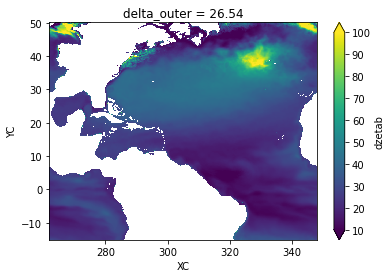

In [79]:
dszb.dzetab.isel(delta_outer=23).plot(vmin=1e1, vmax=1e2)

In [86]:
dszb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Zetab_%2d-%2dmembs/%010d/' 
                                    % (year,36,59,itime))
                           ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                 YG=slice(ystart-12**-1,yend+2*12**-1)
                                ).reset_coords(drop=True)

zetabC = (((dszb.zetab * ds.rA).where(wet_mask!=0.)
           ).isel(YC=slice(1,-1),delta_outer=slice(ts,bs)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc)

maskC100 = ~zetabC.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-100.).to_masked_array().mask
maskC150 = ~zetabC.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).to_masked_array().mask
# plt.pcolormesh(dszb.XC, dszb.YC, 
#               np.ma.masked_array(~mask100, mask100),
#               vmin=0, vmax=3, cmap='autumn', rasterized=True, alpha=.4
#              )

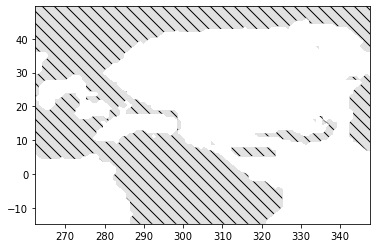

In [87]:
plt.contourf(zetabC.XC.data, zetabC.YC.data, 
              np.ma.masked_array(~maskC150, maskC150), 
             hatches=['\\\\', '\\', '-', '//'],
                  cmap='gray', extend='both', alpha=0.2)

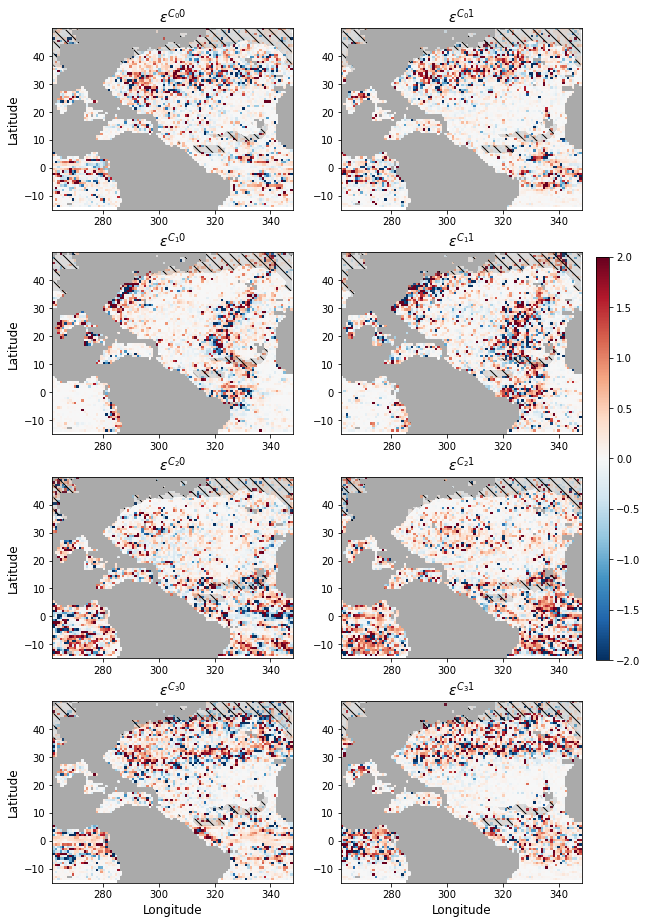

In [89]:
ystart = ySstart

fig, axes = plt.subplots(figsize=(10,16), nrows=4, ncols=2)
        # fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                          dse.ex0.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                          vmax=2., vmin=-2., cmap='RdBu_r')
axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ey0.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ex1.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ey1.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[2,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ex2.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[2,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ey2.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[3,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ex3.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[3,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.ey3.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')


cs0 = axes[0,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs1 = axes[1,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs2 = axes[0,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs3 = axes[1,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs4 = axes[2,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs5 = axes[2,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs6 = axes[3,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs7 = axes[3,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)

for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)
for c in cs6.collections:
    c.set_rasterized(True)
for c in cs7.collections:
    c.set_rasterized(True)
    
axes[0,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[3,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')
axes[3,0].set_aspect('equal')
axes[3,1].set_aspect('equal')

axes[0,0].set_title(r"$\epsilon^{C_00}$", fontsize=14)
axes[0,1].set_title(r"$\epsilon^{C_01}$", fontsize=14)
axes[1,0].set_title(r"$\epsilon^{C_10}$", fontsize=14)
axes[1,1].set_title(r"$\epsilon^{C_11}$", fontsize=14)
axes[2,0].set_title(r"$\epsilon^{C_20}$", fontsize=14)
axes[2,1].set_title(r"$\epsilon^{C_21}$", fontsize=14)
axes[3,0].set_title(r"$\epsilon^{C_30}$", fontsize=14)
axes[3,1].set_title(r"$\epsilon^{C_31}$", fontsize=14)

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_ylabel(r"Latitude", fontsize=12)
axes[3,0].set_xlabel(r"Longitude", fontsize=12)
axes[3,1].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=.86, hspace=.14)
cbax = fig.add_axes([0.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(spec,'figure/PTR-error_1967-01-03.pdf'))

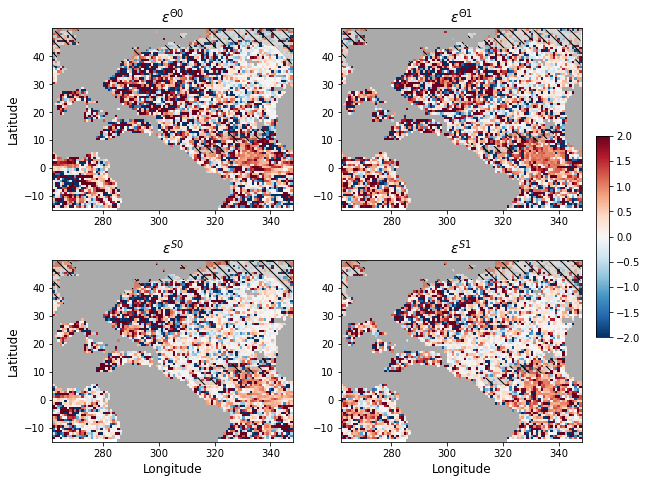

In [90]:
ystart = ySstart

fig, axes = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
        # fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                          dse.exT.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                          vmax=2., vmin=-2., cmap='RdBu_r')
axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.eyT.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.exS.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')
axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(ystart,yend+12**-1)), 
                     dse.eyS.isel(delta_outer=10).sel(YC=slice(ystart,yend+12**-1)), 
                     vmax=2., vmin=-2., cmap='RdBu_r')


cs0 = axes[0,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs1 = axes[1,0].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs2 = axes[0,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)
cs3 = axes[1,1].contourf(zetabC.XC, zetabC.YC,
                         np.ma.masked_array(~maskC150, maskC150), hatches=['\\\\'],
                         cmap='gray', extend='both', alpha=0.2)


for c in cs0.collections:
    c.set_rasterized(True)
for c in cs1.collections:
    c.set_rasterized(True)
for c in cs2.collections:
    c.set_rasterized(True)
for c in cs3.collections:
    c.set_rasterized(True)
for c in cs4.collections:
    c.set_rasterized(True)
for c in cs5.collections:
    c.set_rasterized(True)
for c in cs6.collections:
    c.set_rasterized(True)
for c in cs7.collections:
    c.set_rasterized(True)
    
axes[0,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC.sel(YC=slice(ystart,yend+12**-1)), 
              np.ma.masked_array(maskC, ~maskC),
              vmin=0, vmax=3, cmap='binary', rasterized=True)


axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')


axes[0,0].set_title(r"$\epsilon^{\Theta 0}$", fontsize=14)
axes[0,1].set_title(r"$\epsilon^{\Theta 1}$", fontsize=14)
axes[1,0].set_title(r"$\epsilon^{S0}$", fontsize=14)
axes[1,1].set_title(r"$\epsilon^{S1}$", fontsize=14)

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_xlabel(r"Longitude", fontsize=12)
axes[1,1].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=.86, hspace=.14)
cbax = fig.add_axes([0.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)

plt.savefig(op.join(spec,'figure/ATR-error_1967-01-03.pdf'))

In [92]:
print(np.nanmedian(dse.ex0.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.ey0.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )
print(np.nanmedian(dse.ex1.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.ey1.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )
print(np.nanmedian(dse.ex2.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.ey2.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )
print(np.nanmedian(dse.ex3.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.ey3.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )

0.025654270587669975 0.020813074634597726
0.011783668361592241 0.01083520621682801
0.037187437429205786 0.07256189133342461
0.03344573726386592 0.026080075779720747


In [93]:
print(np.nanmedian(dse.exT.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.eyT.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )
print(np.nanmedian(dse.exS.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.)),
      np.nanmedian(dse.eyS.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.))
      )

0.34318786537090196 0.427920431075544
0.23385645913138647 0.31365973637235434


In [94]:
print(np.nanmedian(dse.ex0.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.ey0.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )
print(np.nanmedian(dse.ex1.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.ey1.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )
print(np.nanmedian(dse.ex2.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.ey2.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )
print(np.nanmedian(dse.ex3.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.ey3.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )

0.014087723441190693 0.005931736119909265
0.025701225347172348 0.008472550581769803
0.03244607316994607 0.05815838275847857
0.003430991152593012 0.0015250367749513


In [95]:
print(np.nanmedian(dse.exT.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.eyT.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )
print(np.nanmedian(dse.exS.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30))),
      np.nanmedian(dse.eyS.isel(delta_outer=10).where(zetabC.isel(delta_outer=10)<-150.).sel(YC=slice(10,30)))
      )

0.2864133911264492 0.3309997090783155
0.18278144106810856 0.2222826458972404
